In [3]:
# Importing the libraries

import numpy as np
import pandas as pd

# Importing pytorch
import torch
import torch.nn as nn
torch.manual_seed(42)

# Importing a data scaler from sklearn (to scale values between 0 and 1 or -1 and 1)
from sklearn.preprocessing import MinMaxScaler

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
plt.rcParams['figure.figsize'] = [14, 10]

In [5]:
# Importing the airline, sunspot and GDP datasets
airline_data = pd.read_csv('./data/airline-passengers.csv')
print(airline_data.head())

sun_data = pd.read_csv('./data/Sun.csv')
print(sun_data.head())

gdp_data = pd.read_csv('./data/GDP.csv')
print(gdp_data.head())

airline_data = np.array(airline_data.iloc[:,1:2].values)
sun_data = np.array(sun_data.iloc[:,1:2].values)
gdp_data = np.array(gdp_data.iloc[:,1:2].values)
print(airline_data.shape, sun_data.shape, gdp_data.shape)

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121
     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0
         DATE       GDP
0  1947-01-01  2033.061
1  1947-04-01  2027.639
2  1947-07-01  2023.452
3  1947-10-01  2055.103
4  1948-01-01  2086.017
(144, 1) (309, 1) (290, 1)


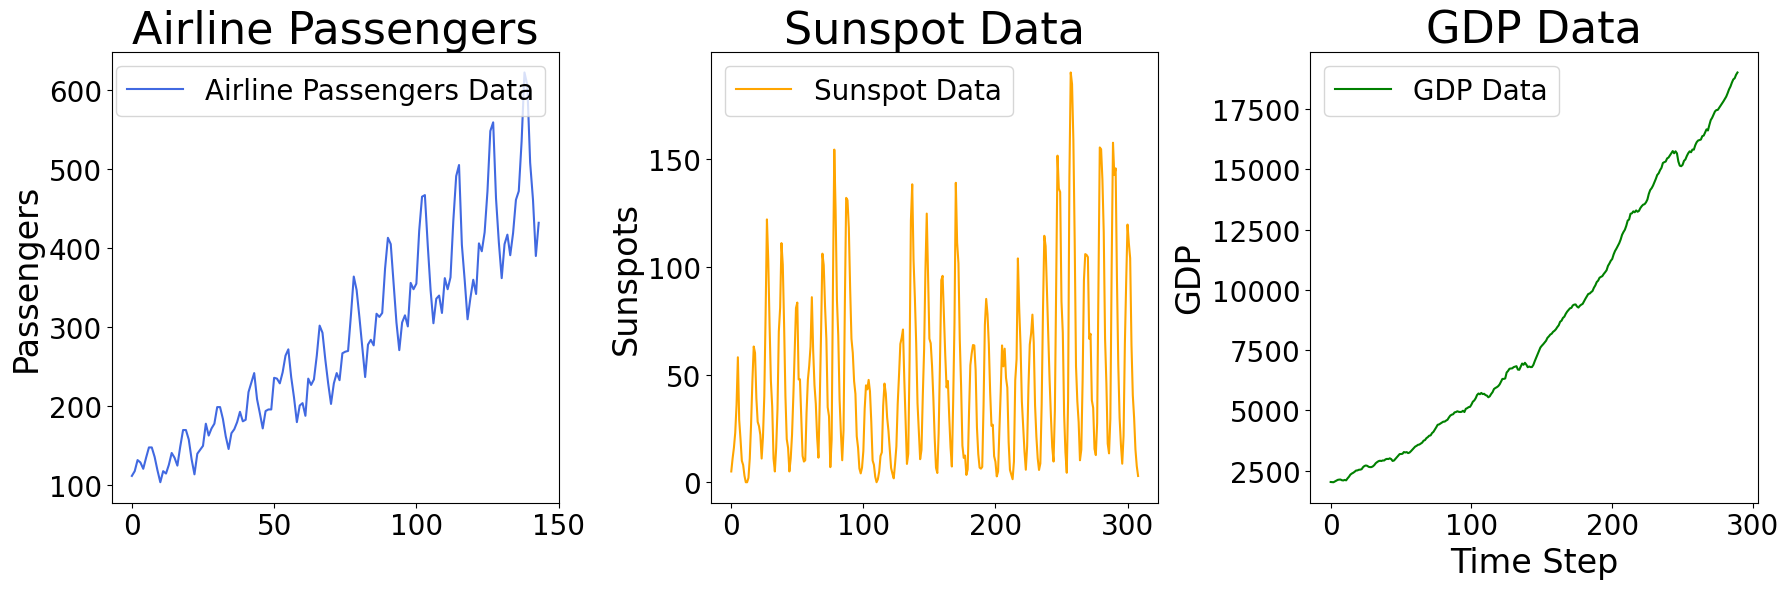

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

label_fontsize = 24  # 12 * 2
title_fontsize = 32  # 16 * 2
legend_fontsize = 20 # 10 * 2
tick_fontsize = 20   # 10 * 2

axs[0].plot(np.array(airline_data), label='Airline Passengers Data', color='royalblue')
axs[0].set_title('Airline Passengers', fontsize=title_fontsize)
axs[0].set_ylabel('Passengers', fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

axs[1].plot(np.array(sun_data), label='Sunspot Data', color='orange')
axs[1].set_title('Sunspot Data', fontsize=title_fontsize)
axs[1].set_ylabel('Sunspots', fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

axs[2].plot(np.array(gdp_data), label='GDP Data', color='green')
axs[2].set_title('GDP Data', fontsize=title_fontsize)
axs[2].set_ylabel('GDP', fontsize=label_fontsize)
axs[2].set_xlabel('Time Step', fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

In [7]:
# Loading the data
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

In [8]:
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
def prepare_data(data, seq_length=8, batch_size=32, train_split=0.7):
    sc = MinMaxScaler()
    data_scaled = sc.fit_transform(data)
    x, y = sliding_windows(data_scaled, seq_length)
    train_size = int(len(y) * train_split)
    
    trainX = torch.Tensor(x[:train_size])
    trainY = torch.Tensor(y[:train_size])
    testX = torch.Tensor(x[train_size:])
    testY = torch.Tensor(y[train_size:])
    
    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return trainX, trainY, testX, testY, train_dataset, train_loader, sc

# Prepare data for airline
airline_trainX, airline_trainY, airline_testX, airline_testY, airline_train_dataset, airline_train_loader, airline_sc = prepare_data(airline_data)

# Prepare data for sun
sun_trainX, sun_trainY, sun_testX, sun_testY, sun_train_dataset, sun_train_loader, sun_sc = prepare_data(sun_data)

# Prepare data for gdp
gdp_trainX, gdp_trainY, gdp_testX, gdp_testY, gdp_train_dataset, gdp_train_loader, gdp_sc = prepare_data(gdp_data)

# Combine all three train datasets
all_train_dataset = ConcatDataset([airline_train_dataset, sun_train_dataset, gdp_train_dataset])
all_train_loader = DataLoader(all_train_dataset, batch_size=16, shuffle=True)

In [9]:
### Define RNN
class RNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # RNN layer
        # Implementing RNN cell from scratch
        self.W_ih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hh = nn.Parameter(torch.Tensor(hidden_size))

        # Initialize parameters
        for param in [self.W_ih, self.W_hh, self.b_ih, self.b_hh]:
          if param.dim() > 1:
            nn.init.xavier_uniform_(param)
          else:
            nn.init.zeros_(param)

        # Linear layer
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        batch_size, seq_length, _ = x.size()

        # Initial hidden state
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Task1: Implment an RNN cell 
        for t in range(seq_length):
            x_t = x[:, t, :]  # x_t shape: (batch_size, input_size)
            # Compute hidden state using tanh activation
            # This is the RNN cell: h_t = tanh(x_t @ W_ih + b_ih + h_{t-1} @ W_hh + b_hh)
            h_t = torch.tanh(
                x_t @ self.W_ih + self.b_ih + 
                h_t @ self.W_hh + self.b_hh
            )
        # After processing the full sequence, use the final hidden state to produce the output
        out = self.fc(h_t.squeeze()) # out shape: (batch_size, num_classes)
        return out    

In [10]:
# GRU model
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Implementing GRU cell from scratch
        self.W_z = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_z = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.Tensor(hidden_size))

        self.W_r = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_r = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.Tensor(hidden_size))

        self.W_h = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.Tensor(hidden_size))

        
        # Linear layer
        self.fc = nn.Linear(hidden_size, num_classes)

        # Initialize parameters
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        batch_size, seq_length, _ = x.size()

        # Initialize hidden state to zeros
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Task2: Implement a GRU cell
        for t in range(seq_length):
            x_t = x[:, t, :]  # shape: (batch_size, input_size)

            # Update gate z_t controls how much of the past to keep
            z_t = torch.sigmoid(x_t @ self.W_z + h_t @ self.U_z + self.b_z)

            # Reset gate r_t controls how much of the past to forget
            r_t = torch.sigmoid(x_t @ self.W_r + h_t @ self.U_r + self.b_r)

            # Candidate hidden state: combines new input with reset-modified history
            h_tilde = torch.tanh(x_t @ self.W_h + (r_t * h_t) @ self.U_h + self.b_h)

            # Final hidden state: mix of old and new based on update gate
            h_t = (1 - z_t) * h_t + z_t * h_tilde
        
        # Use the final hidden state for classification/regression
        out = self.fc(h_t.squeeze()) # shape: (batch_size, num_classes)
        return out


In [11]:
# Training of  the gru units
num_epochs = 100
learning_rate = 0.001

input_size = 1
hidden_size = 6
num_layers = 1
num_classes = 1

def train_model(model, train_loader):
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    train_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for X, Y in train_loader:
            outputs = model(X)
            optimizer.zero_grad()
            loss = criterion(outputs, Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X.size(0)
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
        if epoch % 10 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, epoch_loss))
    return train_losses

In [12]:
gru = GRU(num_classes, input_size, hidden_size, num_layers)
gru_loss = train_model(gru,all_train_loader)


Epoch: 0, loss: 0.03134
Epoch: 10, loss: 0.00516
Epoch: 20, loss: 0.00399
Epoch: 30, loss: 0.00346
Epoch: 40, loss: 0.00314
Epoch: 50, loss: 0.00301
Epoch: 60, loss: 0.00295
Epoch: 70, loss: 0.00279
Epoch: 80, loss: 0.00272
Epoch: 90, loss: 0.00263


In [13]:
rnn = RNN(num_classes, input_size, hidden_size, num_layers)
rnn_loss = train_model(rnn, all_train_loader)

Epoch: 0, loss: 0.08642
Epoch: 10, loss: 0.01658
Epoch: 20, loss: 0.00696
Epoch: 30, loss: 0.00510
Epoch: 40, loss: 0.00440
Epoch: 50, loss: 0.00381
Epoch: 60, loss: 0.00353
Epoch: 70, loss: 0.00316
Epoch: 80, loss: 0.00299
Epoch: 90, loss: 0.00285


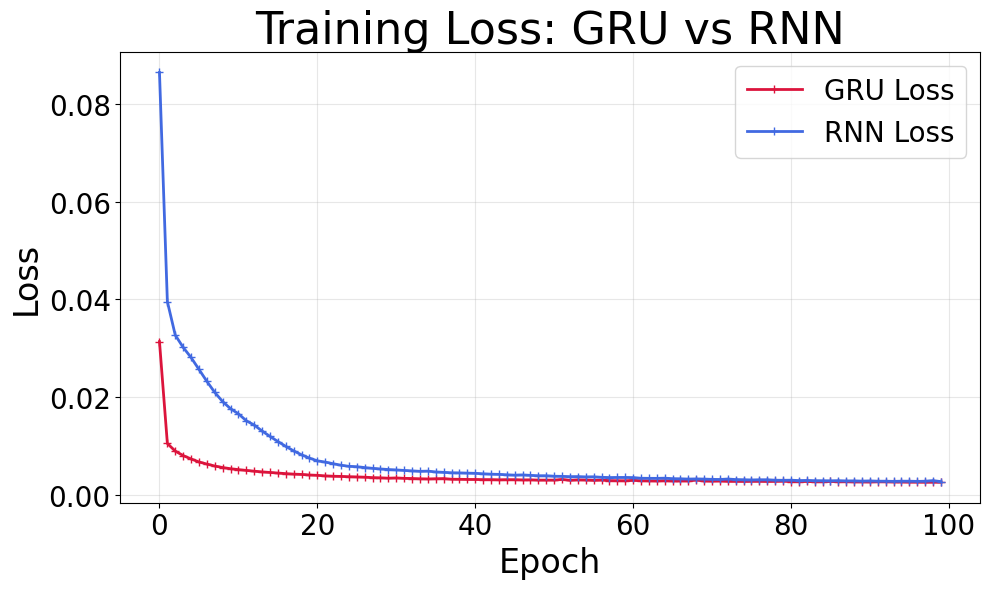

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(gru_loss, '-+', lw=2, label='GRU Loss', color='crimson')
plt.plot(rnn_loss, '-+', lw=2, label='RNN Loss', color='royalblue')
plt.xlabel('Epoch', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
plt.title('Training Loss: GRU vs RNN', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

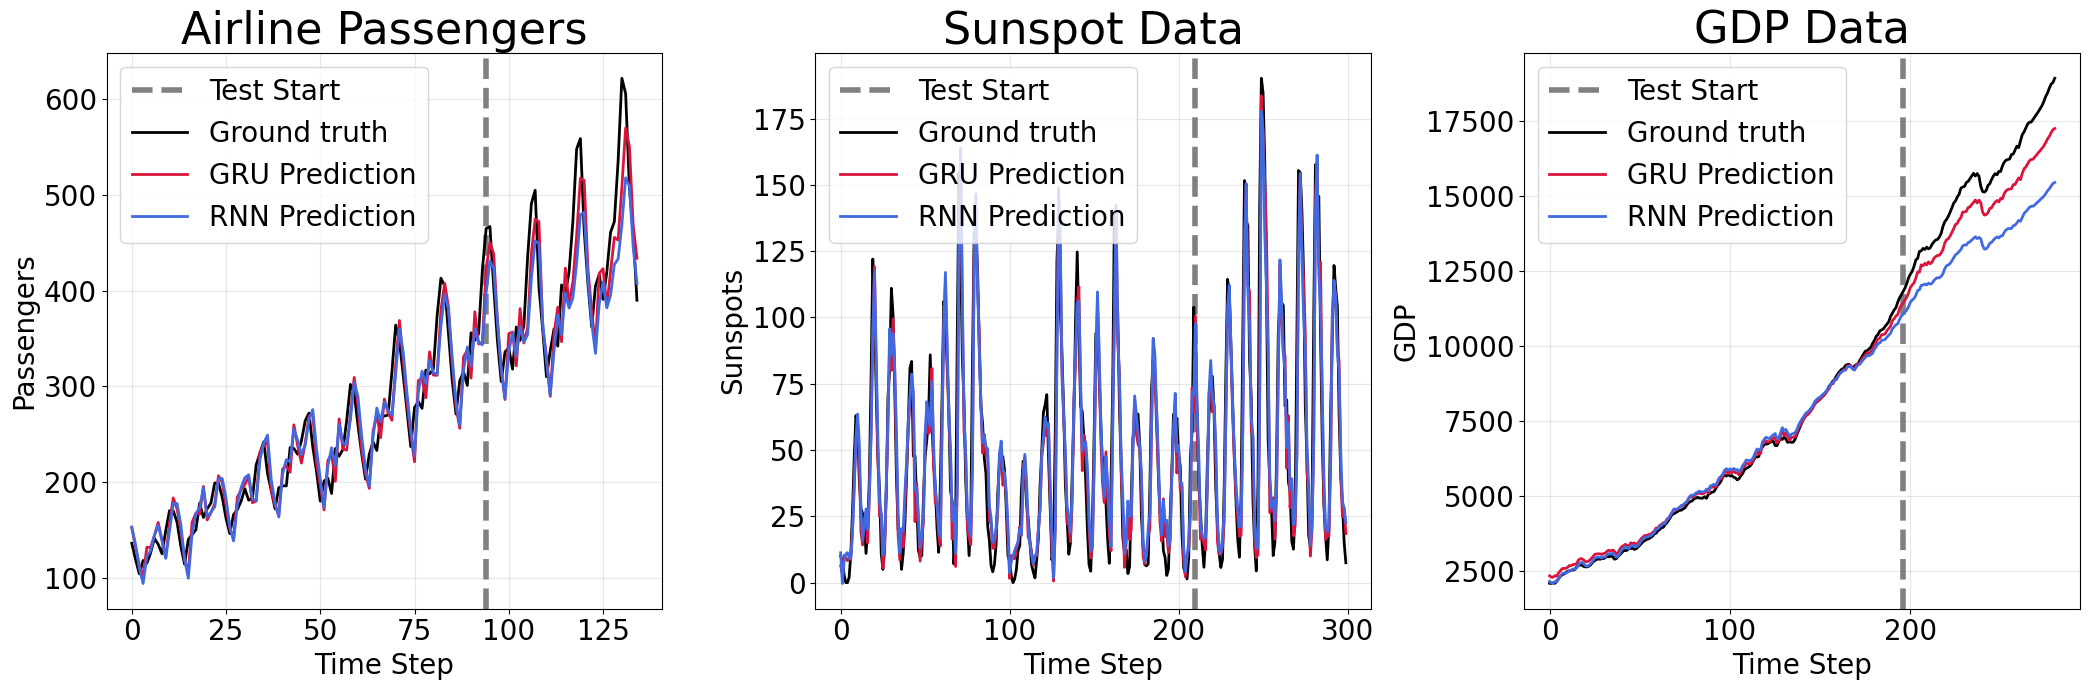

In [15]:
# Set models to evaluation mode
gru.eval()
rnn.eval()

# Helper function to get predictions and inverse transform
def get_predictions(model, X, scaler):
    with torch.no_grad():
        pred = model(X).data.numpy()
    pred = pred.reshape(-1, pred.shape[-1])
    return scaler.inverse_transform(pred)

def get_actual(Y, scaler):
    return scaler.inverse_transform(Y.data.numpy().reshape(-1, Y.shape[-1]))

# Airline
airline_X_full = torch.cat([airline_trainX, airline_testX], dim=0)
airline_gru_pred_full = get_predictions(gru, airline_X_full, airline_sc)
airline_rnn_pred_full = get_predictions(rnn, airline_X_full, airline_sc)

# Sunspot
sun_X_full = torch.cat([sun_trainX, sun_testX], dim=0)
sun_gru_pred_full = get_predictions(gru, sun_X_full, sun_sc)
sun_rnn_pred_full = get_predictions(rnn, sun_X_full, sun_sc)

# GDP
gdp_X_full = torch.cat([gdp_trainX, gdp_testX], dim=0)
gdp_gru_pred_full = get_predictions(gru, gdp_X_full, gdp_sc)
gdp_rnn_pred_full = get_predictions(rnn, gdp_X_full, gdp_sc)

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# Airline
airline_actual = airline_sc.inverse_transform(np.concatenate([airline_trainY, airline_testY], axis=0).reshape(-1, 1))
axs[0].axvline(len(airline_trainY), color='gray', linestyle='--', linewidth=4, label='Test Start')
axs[0].plot(airline_actual, color='black', label='Ground truth', linewidth=2)
axs[0].plot(airline_gru_pred_full, color='crimson', label='GRU Prediction', linewidth=2)
axs[0].plot(airline_rnn_pred_full, color='royalblue', label='RNN Prediction', linewidth=2)
axs[0].set_title('Airline Passengers', fontsize=title_fontsize)
axs[0].set_xlabel('Time Step', fontsize=tick_fontsize)
axs[0].set_ylabel('Passengers', fontsize=tick_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].grid(True, alpha=0.3)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# Sunspot
sun_actual = sun_sc.inverse_transform(np.concatenate([sun_trainY, sun_testY], axis=0).reshape(-1, 1))
axs[1].axvline(len(sun_trainY), color='gray', linestyle='--', linewidth=4, label='Test Start')
axs[1].plot(sun_actual, color='black', label='Ground truth', linewidth=2)
axs[1].plot(sun_gru_pred_full, color='crimson', label='GRU Prediction', linewidth=2)
axs[1].plot(sun_rnn_pred_full, color='royalblue', label='RNN Prediction', linewidth=2)
axs[1].set_title('Sunspot Data', fontsize=title_fontsize)
axs[1].set_xlabel('Time Step', fontsize=tick_fontsize)
axs[1].set_ylabel('Sunspots', fontsize=tick_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].grid(True, alpha=0.3)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# GDP
gdp_actual = gdp_sc.inverse_transform(np.concatenate([gdp_trainY, gdp_testY], axis=0).reshape(-1, 1))
axs[2].axvline(len(gdp_trainY), color='gray', linestyle='--', linewidth=4, label='Test Start')
axs[2].plot(gdp_actual, color='black', label='Ground truth', linewidth=2)
axs[2].plot(gdp_gru_pred_full, color='crimson', label='GRU Prediction', linewidth=2)
axs[2].plot(gdp_rnn_pred_full, color='royalblue', label='RNN Prediction', linewidth=2)
axs[2].set_title('GDP Data', fontsize=title_fontsize)
axs[2].set_xlabel('Time Step', fontsize=tick_fontsize)
axs[2].set_ylabel('GDP', fontsize=tick_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].grid(True, alpha=0.3)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()